# SLCosmo Round-trip Test

In this notebook we exercise `SLCosmo`'s mock data generation and inference methods to simulate a TDC2 submission and infer a Hubble constant that we can compare with the input value. This is a functional test, in the sense that if our round trip does not get us back to where we started, there must be at least one bug in either or both of the mathematics or code. 


In [1]:
import desc.slcosmo
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Generating a Mock TDC2 Submission

In [2]:
Lets = desc.slcosmo.SLCosmo()
Lets.make_some_mock_data(Nlenses=100, Nsamples=100)
Lets.draw_some_prior_samples(Npriorsamples=1000)

## The TDC2 Probabilistic Model

The figure shows the probabilistic graphical model, derived in the draft TDC2 design paper, of a toy cosmological parameter inference given a set of strong lens measurements. We assume that we have, from high resolution imaging and spectroscopic follow-up, lens models that predict the Fermat potential differences $\Delta \phi$ between the image pairs in each of $K$ lens systems.

<img src="pgm.png" width=50%>

We treat the time delays
for each lens as parameters whose posterior PDF (given the light curve
data) can be characterized either as a set of MCMC samples, or as a
multivariate Gaussian. This would be the output from an analysis of the
system's light curves.

With this PDF in hand, our task is to infer $H_0$ given the measured
Fermat potential differences $\Delta \phi$.
The posterior PDF for $H_0$ given a set of $K$ lenses is
\begin{equation}
    \pr(H_0|\{\Delta \phi_k \}) \propto \pr(H_0) \prod_{k=1}^{K} \pr(\Delta \phi_k|H_0),
\end{equation}
where the likelihood function components are the results of
marginalizing over the time delays and time delay distances:
\begin{equation}
    \pr(\Delta \phi_k|H_0) = \iint d\Delta t_k d\Ddt
      \pr(\Delta \phi_k|\Delta t_k, \Ddt^k)
      \pr(\Delta t_k) \delta(\Ddt^k - Q(\zd,\zs)/H_0).
      \label{eq:marginalization}
\end{equation}
The integral over the time delay distance is straightforward, while
the integral over the time delay can be approximated as a sum over the
$N_{\rm s}$ posterior samples provided by the Good Team:
\begin{equation}
    \pr(\Delta \phi_k|H_0) \approx \frac{1}{N_{\rm s}}
       \sum_{j=1}^{N_{\rm s}}
         \pr(\Delta \phi_k|\Delta t_k^j, Q(\zd^k,\zs^k)/H_0).
           \label{eq:sumoversamples}
\end{equation}

We now have, then, the function that we need to evaluate at each sample
$\Delta t_k$ value, in Equation~\ref{eq:sumoversamples}:
\begin{align}
    \pr(\Delta \phi_k|\Delta t_k, Q(\zd^k,\zs^k)/H_0) &=
        \frac{1}{\sqrt{(2\pi\sigma_k^2)}} \exp\left[ -\frac{\chi^2}{2} \right] \\
    {\rm where\;\;\;} \chi^2 &= \frac{ \left( \Delta \phi_k - \frac{c H_0 \Delta t_k}{Q(\zd^k,\zs^k)} \right)^2 }{\sigma_k^2}.
\end{align}

## Inference of $H_0$

In [3]:
Lets.compute_the_joint_log_likelihood()

Wallclock time spent characterizing posterior =  113.0 seconds


In [4]:
Lets.report_the_inferred_cosmological_parameters()

H0 = 73.1 +/- 0.8 km/s/Mpc
True H0 = 72.3 km/s/Mpc


Plot saved to H0posterior.pdf


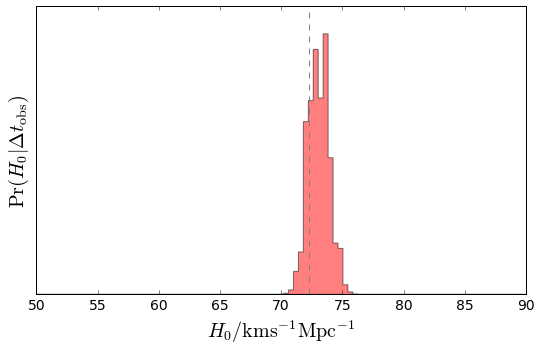

In [5]:
Lets.plot_the_inferred_cosmological_parameters()

## Conclusions

* The true value of $H_0$ seems to be recovered accurately
* The calculation is slow. For 100 lenses, each with 100 posterior samples, it takes 0.11 seconds per prior samples, or 2 minutes for a reasonable size set of 1000 prior samples. This is OK for analysis runs, but we'll want to investigate the number of prior samples to draw - and this is a bit slow for experimenting with.